# Basic Settings

In [82]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools

E: Package 'python-software-properties' has no installation candidate


In [83]:
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null

In [84]:
!apt-get update -qq 2>&1 /dev/null

E: The update command takes no arguments


In [4]:
!apt-get -y install -qq google-drive-ocamlfuse fuse

Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 160772 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.26-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.26-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.26-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [5]:
import os.path

In [6]:
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()

In [7]:
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [8]:
!mkdir -p Gdrive

In [9]:
!google-drive-ocamlfuse Gdrive

In [10]:
!ls Gdrive/DJ_crawling/

2011.png	  aus_pos_2020.png			 jap_pos_2015.png
2012.png	  aus_sentiment.csv			 jap_pos_2016.png
2013.png	  data_australia.csv			 jap_pos_2017.png
2014.png	  data.csv				 jap_pos_2018.png
2015.png	  data_japan.csv			 jap_pos_2019.png
2016.png	  fail_data_dataframe_australia.csv	 jap_pos_2020.png
2017.png	  fail_data_dataframe.csv		 jap_sentiment.csv
2018.png	  fail_data_dataframe_japan.csv		 kor_pos_2011.png
2019.png	  fail_data_dataframe_us1.csv		 kor_pos_2012.png
2020.png	  fail_data_dataframe_us2.csv		 kor_pos_2013.png
aus_pos_2011.png  final_content_australia_dataframe.csv  kor_pos_2014.png
aus_pos_2012.png  final_content_dataframe.csv		 kor_pos_2015.png
aus_pos_2013.png  final_content_japan_dataframe.csv	 kor_pos_2016.png
aus_pos_2014.png  final_content_us_dataframe1.csv	 kor_pos_2017.png
aus_pos_2015.png  final_content_us_dataframe2.csv	 kor_pos_2018.png
aus_pos_2016.png  jap_pos_2011.png			 kor_pos_2019.png
aus_pos_2017.png  jap_pos_2012.png			 kor_pos_2020.png
aus_pos_2018.png 

# Basic Processing libraries

In [ ]:
!pip install afinn
!pip install lime
!pip install pyLDAvis

In [13]:
import csv
import time
import os.path
from __future__ import division
from afinn import Afinn
import numpy as np
import pandas as pd
from collections import Counter
from matplotlib import pyplot as plt
from bs4 import BeautifulSoup
from nltk.corpus import wordnet, stopwords
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.tokenize import WordPunctTokenizer
from google.colab import files
import re
import seaborn as sns
import nltk
import warnings
import unicodedata
import spacy
nlp = spacy.load('en', parse = False, tag=False, entity=False)
nltk.download('stopwords')
nltk.download('wordnet')
warnings.filterwarnings("ignore")
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [14]:
#####Preprocessing Functions
from nltk.tokenize import WordPunctTokenizer
#Remove Stopwords
tok = WordPunctTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')


def text_cleaner(text):
    soup = BeautifulSoup(text, "html.parser") 
    souped = soup.get_text()
    #remove accented text
    de_accent = unicodedata.normalize('NFKD', souped).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    #letters only
    letters_only = re.sub("[^a-zA-Z]", " ", de_accent)
    #lemmatization
    text = nlp(letters_only)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    #remove stopwords
    lower_case = text.lower()
    words = tok.tokenize(lower_case)
    words = [token.strip() for token in words]
    filtered_tokens = [token for token in words if token not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return (" ".join(words)).strip()

# Kor_data

## Load CSV

In [11]:
import pandas as pd 
import re
import numpy as np
import requests
from dateutil.parser import parse
kor_content = pd.read_csv('Gdrive/DJ_crawling/final_content_dataframe.csv')  ; kor_content
kor_content['year'] = kor_content.apply(lambda row: parse(row['year'], fuzzy=True).year, axis=1)
kor_content

,title,year,content
0,Spotify launches in South Korea,2021,"<div class=""post-content clearfix"" style=""font..."
1,Zynga launches Harry Potter: Puzzles & Spells ...,2021,"<div class=""post-content clearfix"" style=""font..."
2,Enjoy the amazing K-contents online... Korea G...,2021,"<div class=""post-content clearfix"" style=""font..."
3,"Indonesia, S Korea explore greater cooperation...",2021,"<div class=""post-content clearfix"" style=""font..."
4,FM should be proactive in releasing Korean tan...,2021,"<div class=""post-content clearfix"" style=""font..."
...,...,...,...
654,N.Korea slams S.Korea`s rejection of talks,2011,"<div class=""post-content clearfix"" style=""font..."
655,N. Korea officially proposes talks with South:...,2011,"<div class=""post-content clearfix"" style=""font..."
656,S.Korea holds computer-simulated war games,2011,"<div class=""post-content clearfix"" style=""font..."
657,North Korea asks RI to help create peace,2011,"<div class=""post-content clearfix"" style=""font..."


## preprocess tags

In [18]:
# remove tag, http, emails
Data_list = kor_content['content'].values.tolist(); Data_list
Data_list_sub = [re.sub('<[^>]+>',' ', sub) for sub in Data_list]
Data_list_sub_2 = [re.sub(r'http\S+','', sub) for sub in Data_list_sub]
Data_list_sub_2 = [re.sub(r'\S*@\S*\s?','', sub) for sub in Data_list_sub_2]
sample = [s.strip() for s in Data_list_sub_2]
sample_df = pd.DataFrame(sample, columns=["content"]);sample_df
years=kor_content["year"].values.tolist()
sample_df['year'] = years

,content
0,World’s most popular audio streaming subscript...
1,Award-winning hit mobile game released on the ...
2,"- For 46 days from January 14, as an online pr..."
3,I invite and welcome ideas and investments fro...
4,The Foreign Ministry must be active in releasi...
...,...
654,Seoul (ANTARA News/AFP) - North Korea on Tuesd...
655,Seoul (ANTARA News/AFP) - North Korea Monday o...
656,Seoul (ANTARA News/AFP) - South Korea held war...
657,Jakarta (ANTARA News) - North Korea has asked ...


In [31]:
## split into sentence using nltk
# !pip install nltk
# import nltk
# nltk.download('punkt')
# from nltk.tokenize import sent_tokenize
# # nltk
# sent_df = sample_df.loc[:, "content"].apply(lambda x: sent_tokenize(x))

#split into sentence using spacy
nlp = spacy.load("en_core_web_sm")
sample_df["content"] = sample_df["content"].apply(lambda x: [sent.text for sent in nlp(x).sents])
df = sample_df.explode("content", ignore_index=True)
df.rename(columns={"Unnamed: 0": "article ID"}, inplace=True)
df.index.name = "Sentence ID"
df.head()

In [ ]:
# Looping over every tweet in the data set and applying the tweet_cleaner function it.
clean_texts = []
for tweet in df.content:
    clean_texts.append(text_cleaner(tweet))
clean_texts

In [39]:
df['clean_text'] = clean_texts
df

,content,year,clean_text
Sentence ID,,,
0,World’s most popular audio streaming subscript...,2021,world most popular audio stream subscription s...
1,"Seoul, South Korea--(Antara/Business Wire)-",2021,seoul south korea antara business wire
2,Today Spotify (NYSE: SPOT) launches its servic...,2021,today spotify nyse spot launch its service in ...
3,As the world’s most popular audio streaming su...,2021,as the world most popular audio stream subscri...
4,This launch brings Spotify’s total number of m...,2021,this launch bring spotifys total number of mar...
...,...,...,...
11016,Siti Hajar was the victim of her employer`s br...,2011,siti hajar be the victim of her employer s bru...
11017,Three other Indonesian workers were also shot ...,2011,three other indonesian worker be also shoot de...
11018,"""Don`t let new violence cases happen but old c...",2011,don t let new violence case happen but old cas...


## Get Afinnn Scores

In [40]:
!pip install pandas==1.1.3

     |████████████████████████████████| 9.5MB 6.1MB/s 
ERROR: pyldavis 3.3.1 has requirement pandas>=1.2.0, but you'll have pandas 1.1.3 which is incompatible.
  Found existing installation: pandas 1.2.4
    Uninstalling pandas-1.2.4:
      Successfully uninstalled pandas-1.2.4


In [41]:
# Sentiment analysis with AFINN
afinn = Afinn(emoticons=True)
afinn_scores = [afinn.score(clean_text) for clean_text in df.clean_text]
df['sentiment'] = afinn_scores
# Save to a new csv
# sample_df.to_csv('kor_sentiment.csv')
# !cp kor_sentiment.csv "Gdrive/DJ_crawling/"
# sample_df.to_csv('Gdrive/DJ_crawling/kor_2011_scores.csv', index=False, header=True)
# sample_df

In [46]:
df['sentiment'].describe() ;df

,content,year,clean_text,sentiment
Sentence ID,,,,
0,World’s most popular audio streaming subscript...,2021,world most popular audio stream subscription s...,3.0
1,"Seoul, South Korea--(Antara/Business Wire)-",2021,seoul south korea antara business wire,0.0
2,Today Spotify (NYSE: SPOT) launches its servic...,2021,today spotify nyse spot launch its service in ...,0.0
3,As the world’s most popular audio streaming su...,2021,as the world most popular audio stream subscri...,7.0
4,This launch brings Spotify’s total number of m...,2021,this launch bring spotifys total number of mar...,0.0
...,...,...,...,...
11016,Siti Hajar was the victim of her employer`s br...,2011,siti hajar be the victim of her employer s bru...,-2.0
11017,Three other Indonesian workers were also shot ...,2011,three other indonesian worker be also shoot de...,-4.0
11018,"""Don`t let new violence cases happen but old c...",2011,don t let new violence case happen but old cas...,-6.0


In [50]:
predicted_sentiments = []
for score in afinn_scores:
  if score >= 1:
    predicted_sentiments.append("positive")
  elif score <= -1:
    predicted_sentiments.append("negative")
  else:
    predicted_sentiments.append("neutral")
df['postivity'] = predicted_sentiments ;df

In [53]:
df.to_csv('kor_sent_sentiment.csv')
!cp kor_sent_sentiment.csv "Gdrive/DJ_crawling/"

## Analizing Yearly Positivity

In [54]:
subset_df_2011 = df["year"] == 2011
subset_df_2012 = df["year"] == 2012
subset_df_2013 = df["year"] == 2013
subset_df_2014 = df["year"] == 2014
subset_df_2015 = df["year"] == 2015
subset_df_2016 = df["year"] == 2016
subset_df_2017 = df["year"] == 2017
subset_df_2018 = df["year"] == 2018
subset_df_2019 = df["year"] == 2019
subset_df_2020 = df["year"] == 2020

dt_2011 = df[subset_df_2011]
dt_2012 = df[subset_df_2012]
dt_2013 = df[subset_df_2013]
dt_2014 = df[subset_df_2014]
dt_2015 = df[subset_df_2015]
dt_2016 = df[subset_df_2016]
dt_2017 = df[subset_df_2017]
dt_2018 = df[subset_df_2018]
dt_2019 = df[subset_df_2019]
dt_2020 = df[subset_df_2020]

# Data_list_2011=dt_2011["content"].values.tolist()
# Data_list_2012=dt_2012["content"].values.tolist()
# Data_list_2013=dt_2013["content"].values.tolist()
# Data_list_2014=dt_2014["content"].values.tolist()
# Data_list_2015=dt_2015["content"].values.tolist()
# Data_list_2016=dt_2016["content"].values.tolist()
# Data_list_2017=dt_2017["content"].values.tolist()
# Data_list_2018=dt_2018["content"].values.tolist()
# Data_list_2019=dt_2019["content"].values.tolist()
# Data_list_2020=dt_2020["content"].values.tolist()

### 2011

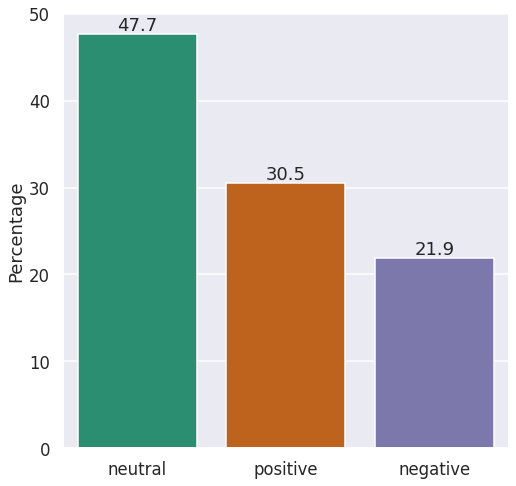

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', context='talk', palette='Dark2')
fig, ax = plt.subplots(figsize=(8, 8))
counts = dt_2011.postivity.value_counts(normalize=True) * 100
splot = sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(counts.index)
ax.set_ylabel("Percentage")

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.savefig("Gdrive/DJ_crawling/kor_sent_pos_2011.png")
plt.show()

### 2012

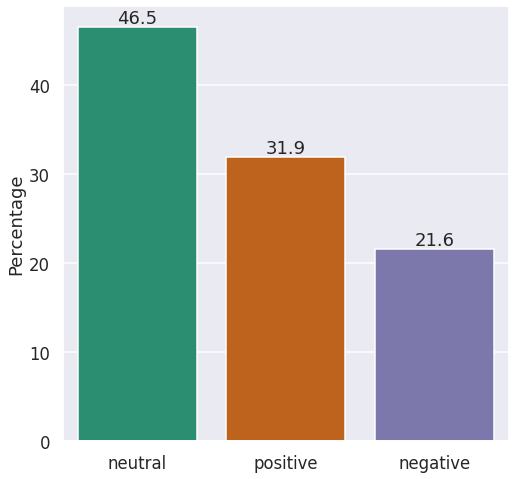

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', context='talk', palette='Dark2')
fig, ax = plt.subplots(figsize=(8, 8))
counts = dt_2012.postivity.value_counts(normalize=True) * 100
splot = sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(counts.index)
ax.set_ylabel("Percentage")

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.savefig("Gdrive/DJ_crawling/kor_sent_pos_2012.png")
plt.show()

### 2013

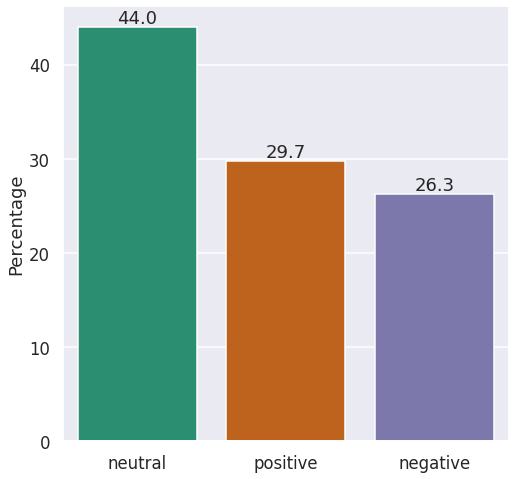

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', context='talk', palette='Dark2')
fig, ax = plt.subplots(figsize=(8, 8))
counts = dt_2013.postivity.value_counts(normalize=True) * 100
splot = sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(counts.index)
ax.set_ylabel("Percentage")

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.savefig("Gdrive/DJ_crawling/kor_sent_pos_2013.png")
plt.show()

### 2014

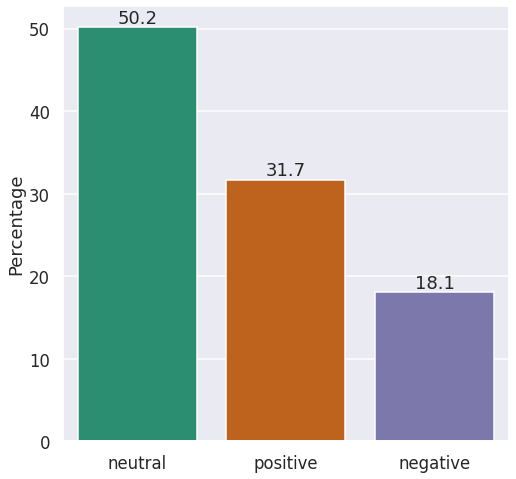

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', context='talk', palette='Dark2')
fig, ax = plt.subplots(figsize=(8, 8))
counts = dt_2014.postivity.value_counts(normalize=True) * 100
splot = sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(counts.index)
ax.set_ylabel("Percentage")

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.savefig("Gdrive/DJ_crawling/kor_sent_pos_2014.png")
plt.show()

### 2015

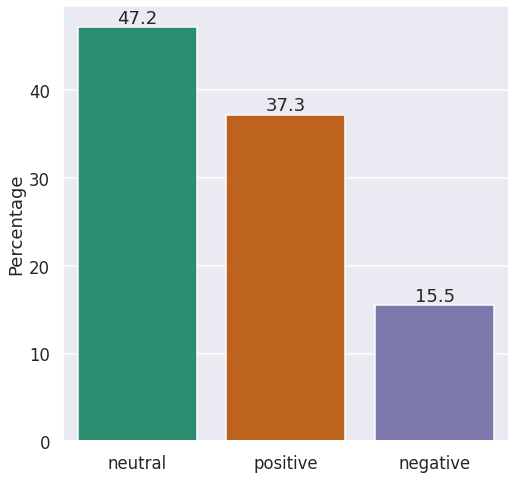

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', context='talk', palette='Dark2')
fig, ax = plt.subplots(figsize=(8, 8))
counts = dt_2015.postivity.value_counts(normalize=True) * 100
splot = sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(counts.index)
ax.set_ylabel("Percentage")

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.savefig("Gdrive/DJ_crawling/kor_sent_pos_2015.png")
plt.show()

### 2016

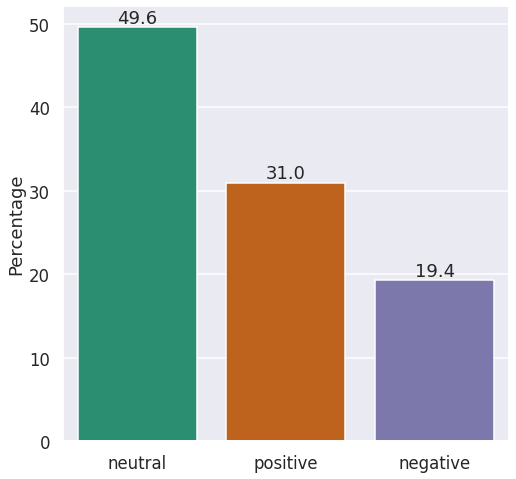

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', context='talk', palette='Dark2')
fig, ax = plt.subplots(figsize=(8, 8))
counts = dt_2016.postivity.value_counts(normalize=True) * 100
splot = sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(counts.index)
ax.set_ylabel("Percentage")

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.savefig("Gdrive/DJ_crawling/kor_sent_pos_2016.png")
plt.show()

### 2017

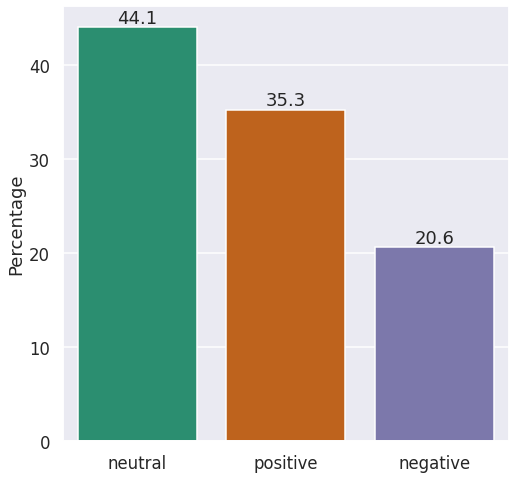

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', context='talk', palette='Dark2')
fig, ax = plt.subplots(figsize=(8, 8))
counts = dt_2017.postivity.value_counts(normalize=True) * 100
splot = sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(counts.index)
ax.set_ylabel("Percentage")

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.savefig("Gdrive/DJ_crawling/kor_sent_pos_2017.png")
plt.show()

### 2018

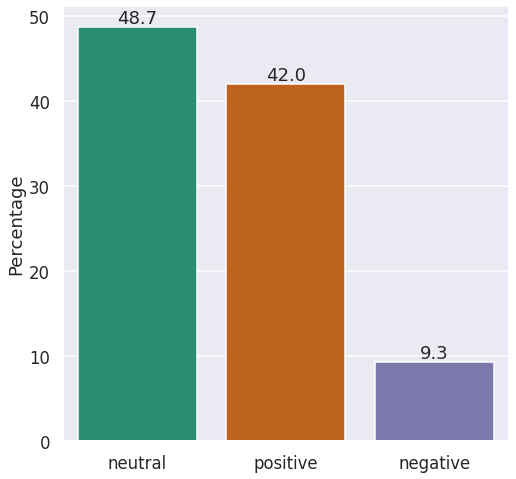

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', context='talk', palette='Dark2')
fig, ax = plt.subplots(figsize=(8, 8))
counts = dt_2018.postivity.value_counts(normalize=True) * 100
splot = sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(counts.index)
ax.set_ylabel("Percentage")

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.savefig("Gdrive/DJ_crawling/kor_sent_pos_2018.png")
plt.show()

### 2019

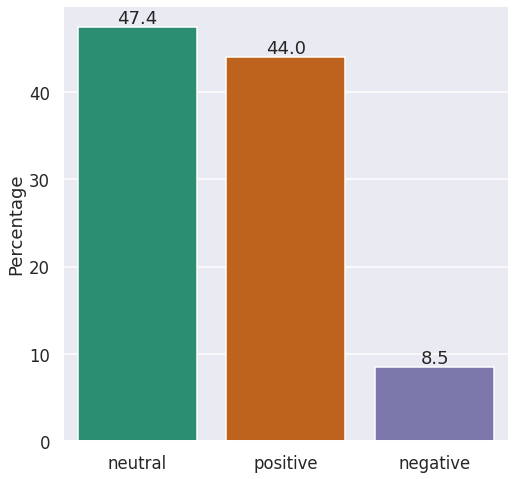

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', context='talk', palette='Dark2')
fig, ax = plt.subplots(figsize=(8, 8))
counts = dt_2019.postivity.value_counts(normalize=True) * 100
splot = sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(counts.index)
ax.set_ylabel("Percentage")

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.savefig("Gdrive/DJ_crawling/kor_sent_pos_2019.png")
plt.show()

### 2020

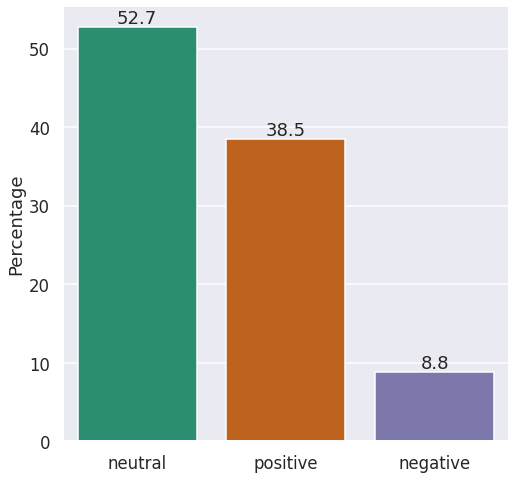

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', context='talk', palette='Dark2')
fig, ax = plt.subplots(figsize=(8, 8))
counts = dt_2020.postivity.value_counts(normalize=True) * 100
splot = sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(counts.index)
ax.set_ylabel("Percentage")

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.savefig("Gdrive/DJ_crawling/kor_sent_pos_2020.png")
plt.show()

In [ ]:
kor_data_grouped = sample_df.groupby('year')['postivity'].value_counts(normalize=True)

In [ ]:
kor_data_grouped

year  postivity
2011  negative     0.521739
      positive     0.478261
2012  positive     0.530612
      negative     0.469388
2013  negative     0.558824
      positive     0.441176
2014  positive     0.531250
      negative     0.468750
2015  positive     0.625000
      negative     0.375000
2016  positive     0.602941
      negative     0.397059
2017  positive     0.644444
      negative     0.355556
2018  positive     0.911111
      negative     0.088889
2019  positive     0.895833
      negative     0.104167
2020  positive     0.866667
      negative     0.133333
2021  positive     0.800000
      negative     0.200000
Name: postivity, dtype: float64

In [ ]:
kor_data_grouped_unstacked = sample_df.groupby('year')['postivity'].value_counts(normalize=True).unstack().fillna(0)

In [ ]:
kor_data_grouped_unstacked 

postivity,negative,positive
year,,
2011,0.521739,0.478261
2012,0.469388,0.530612
2013,0.558824,0.441176
2014,0.468750,0.531250
2015,0.375000,0.625000
2016,0.397059,0.602941
2017,0.355556,0.644444
2018,0.088889,0.911111
2019,0.104167,0.895833


# Japan_data

## Load CSV

In [ ]:
# !ls 'Gdrive/DJ_crawling/'

2011.png	    data_japan.csv			   kor_pos_2012.png
2012.png	    fail_data_dataframe_australia.csv	   kor_pos_2013.png
2013.png	    fail_data_dataframe.csv		   kor_pos_2014.png
2014.png	    fail_data_dataframe_japan.csv	   kor_pos_2015.png
2015.png	    fail_data_dataframe_us1.csv		   kor_pos_2016.png
2016.png	    fail_data_dataframe_us2.csv		   kor_pos_2017.png
2017.png	    final_content_australia_dataframe.csv  kor_pos_2018.png
2018.png	    final_content_dataframe.csv		   kor_pos_2019.png
2019.png	    final_content_japan_dataframe.csv	   kor_pos_2020.png
2020.png	    final_content_us_dataframe1.csv	   kor_sentiment.csv
data_australia.csv  final_content_us_dataframe2.csv	   us.csv
data.csv	    kor_pos_2011.png


In [65]:
jap_content = pd.read_csv('Gdrive/DJ_crawling/final_content_japan_dataframe.csv')  
jap_content['year'] = jap_content.apply(lambda row: parse(row['year'], fuzzy=True).year, axis=1)
jap_content

,title,year,content
0,"National Crafts Museum, Japan to hold third of...",2021,"<div class=""post-content clearfix"" style=""font..."
1,Proxy Bidding and Shopping Service FROM JAPAN ...,2021,"<div class=""post-content clearfix"" style=""font..."
2,Ministry of Environment to hold online environ...,2021,"<div class=""post-content clearfix"" style=""font..."
3,Vaname shrimp exports from Southeast Sulawesi ...,2021,"<div class=""post-content clearfix"" style=""font..."
4,Indonesian industry minister meets METI offici...,2021,"<div class=""post-content clearfix"" style=""font..."
...,...,...,...
912,Japan interested in kesambi oil investment,2011,"<div class=""post-content clearfix"" style=""font..."
913,Japan`s `convict` monkey escapes again,2011,"<div class=""post-content clearfix"" style=""font..."
914,Japan pm enjoys poll boost after reshuffle,2011,"<div class=""post-content clearfix"" style=""font..."
915,"RI, Japan to expand defense cooperation",2011,"<div class=""post-content clearfix"" style=""font..."


## preprocess tags

In [66]:
Data_list = jap_content['content'].values.tolist(); Data_list
Data_list_sub = [re.sub('<[^>]+>',' ', sub) for sub in Data_list]
Data_list_sub_2 = [re.sub(r'http\S+','', sub) for sub in Data_list_sub]
Data_list_sub_2 = [re.sub(r'\S*@\S*\s?','', sub) for sub in Data_list_sub_2]
sample = [s.strip() for s in Data_list_sub_2]
sample_df = pd.DataFrame(sample, columns=["content"]);sample_df
years=jap_content["year"].values.tolist()
sample_df['year'] = years

#split into sentence using spacy
nlp = spacy.load("en_core_web_sm")
sample_df["content"] = sample_df["content"].apply(lambda x: [sent.text for sent in nlp(x).sents])
df = sample_df.explode("content", ignore_index=True)
df.rename(columns={"Unnamed: 0": "article ID"}, inplace=True)
df.index.name = "Sentence ID"
df.head()
# Looping over every tweet in the data set and applying the tweet_cleaner function it.
clean_texts = []
for tweet in df.content:
    clean_texts.append(text_cleaner(tweet))
clean_texts
# merge with original data the clean test
df['clean_text'] = clean_texts
df


,content,year,clean_text
Sentence ID,,,
0,"AsiaNet 88385\r\n \n Kanazawa, Japan, Mar...",2021,asianet kanazawa japan mar
1,(Antara/Kyodo JBN-AsiaNet) - The National Craf...,2021,antara kyodo jbn asianet the national crafts m...
2,"Furnishings in Each Season"" from April 29 to J...",2021,furnishing in each season from april to july
3,"The museum houses about 3,900 works from the l...",2021,the museum house about work from the late th c...
4,These works cover various fields including cer...,2021,these work cover various field include ceramic...
...,...,...,...
16377,", Kyodo News reported. \r\n",2011,kyodo news report
16378,Saudi Arabia plans to build nuclear power plan...,2011,saudi arabia plan to build nuclear power plant...
16379,Ohata offered Riyadh assistance in training Sa...,2011,ohata offer riyadh assistance in training saud...


## Get Afinn Scores

In [67]:
# afinn = Afinn(emoticons = True)
# afinn.score('This is utterly excellent!;)')

# Sentiment analysis with AFINN
afinn = Afinn(emoticons=True)
afinn_scores = [afinn.score(clean_text) for clean_text in df.clean_text]

#add label
predicted_sentiments = []
for score in afinn_scores:
  if score >= 1:
    predicted_sentiments.append("positive")
  elif score <= -1:
    predicted_sentiments.append("negative")
  else:
    predicted_sentiments.append("neutral")
df['postivity'] = predicted_sentiments ;df

df.to_csv('jap_sent_sentiment.csv')
!cp jap_sent_sentiment.csv "Gdrive/DJ_crawling/"

## Anlyzing yearly positivity

In [68]:
subset_df_2011 = df["year"] == 2011
subset_df_2012 = df["year"] == 2012
subset_df_2013 = df["year"] == 2013
subset_df_2014 = df["year"] == 2014
subset_df_2015 = df["year"] == 2015
subset_df_2016 = df["year"] == 2016
subset_df_2017 = df["year"] == 2017
subset_df_2018 = df["year"] == 2018
subset_df_2019 = df["year"] == 2019
subset_df_2020 = df["year"] == 2020

dt_2011 = df[subset_df_2011]
dt_2012 = df[subset_df_2012]
dt_2013 = df[subset_df_2013]
dt_2014 = df[subset_df_2014]
dt_2015 = df[subset_df_2015]
dt_2016 = df[subset_df_2016]
dt_2017 = df[subset_df_2017]
dt_2018 = df[subset_df_2018]
dt_2019 = df[subset_df_2019]
dt_2020 = df[subset_df_2020]

# Data_list_2011=dt_2011["content"].values.tolist()
# Data_list_2012=dt_2012["content"].values.tolist()
# Data_list_2013=dt_2013["content"].values.tolist()
# Data_list_2014=dt_2014["content"].values.tolist()
# Data_list_2015=dt_2015["content"].values.tolist()
# Data_list_2016=dt_2016["content"].values.tolist()
# Data_list_2017=dt_2017["content"].values.tolist()
# Data_list_2018=dt_2018["content"].values.tolist()
# Data_list_2019=dt_2019["content"].values.tolist()
# Data_list_2020=dt_2020["content"].values.tolist()

### 2011

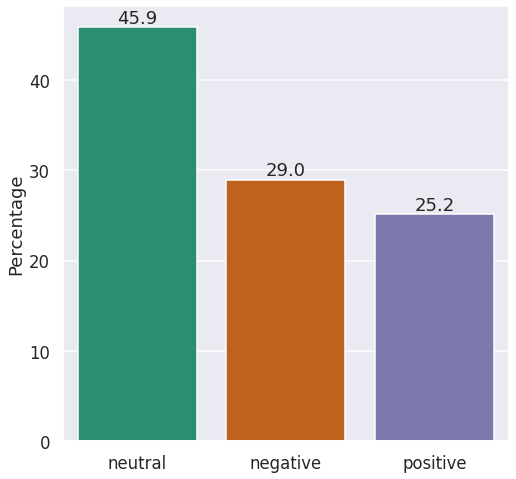

In [69]:
sns.set(style='darkgrid', context='talk', palette='Dark2')
fig, ax = plt.subplots(figsize=(8, 8))
counts = dt_2011.postivity.value_counts(normalize=True) * 100
splot = sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(counts.index)
ax.set_ylabel("Percentage")

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.savefig("Gdrive/DJ_crawling/jap_sent_pos_2011.png")
plt.show()

### 2012

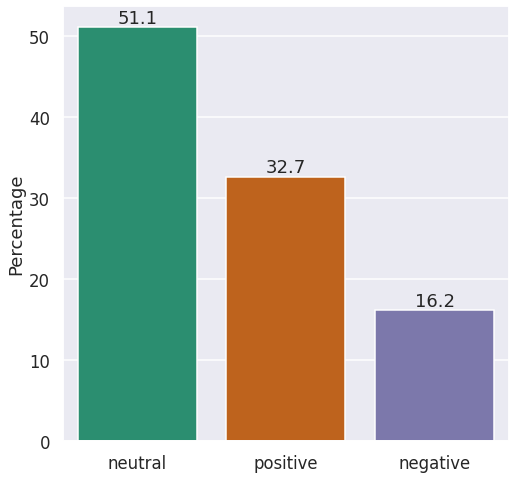

In [70]:
sns.set(style='darkgrid', context='talk', palette='Dark2')
fig, ax = plt.subplots(figsize=(8, 8))
counts = dt_2012.postivity.value_counts(normalize=True) * 100
splot = sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(counts.index)
ax.set_ylabel("Percentage")

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.savefig("Gdrive/DJ_crawling/jap_sent_pos_2012.png")
plt.show()

### 2013

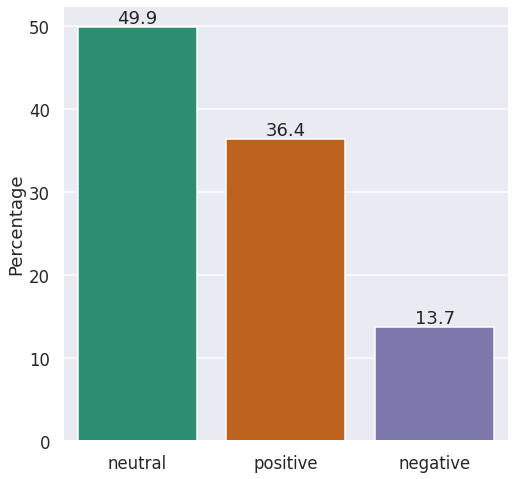

In [71]:
sns.set(style='darkgrid', context='talk', palette='Dark2')
fig, ax = plt.subplots(figsize=(8, 8))
counts = dt_2013.postivity.value_counts(normalize=True) * 100
splot = sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(counts.index)
ax.set_ylabel("Percentage")

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.savefig("Gdrive/DJ_crawling/jap_sent_pos_2013.png")
plt.show()

### 2014

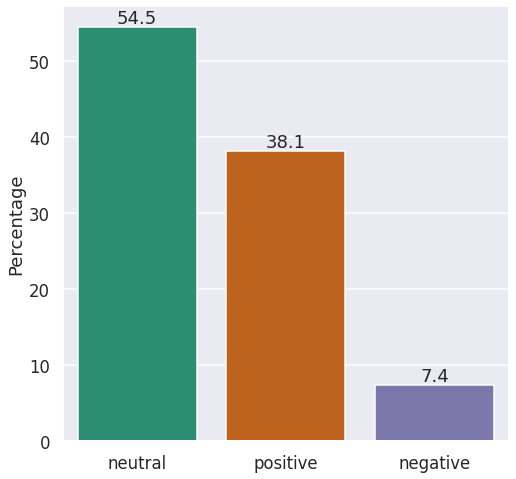

In [72]:
sns.set(style='darkgrid', context='talk', palette='Dark2')
fig, ax = plt.subplots(figsize=(8, 8))
counts = dt_2014.postivity.value_counts(normalize=True) * 100
splot = sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(counts.index)
ax.set_ylabel("Percentage")

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.savefig("Gdrive/DJ_crawling/jap_sent_pos_2014.png")
plt.show()

### 2015

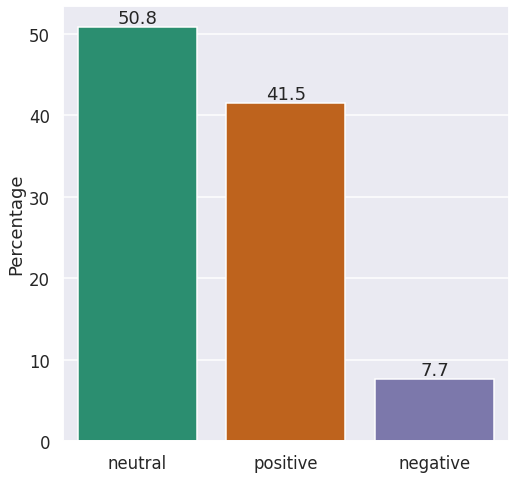

In [73]:
sns.set(style='darkgrid', context='talk', palette='Dark2')
fig, ax = plt.subplots(figsize=(8, 8))
counts = dt_2015.postivity.value_counts(normalize=True) * 100
splot = sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(counts.index)
ax.set_ylabel("Percentage")

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.savefig("Gdrive/DJ_crawling/jap_sent_pos_2015.png")
plt.show()

### 2016

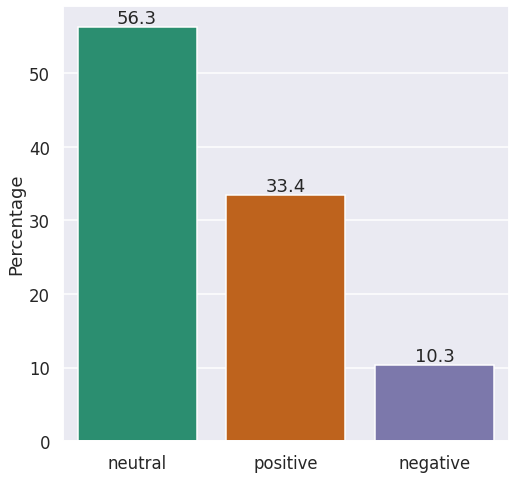

In [74]:
sns.set(style='darkgrid', context='talk', palette='Dark2')
fig, ax = plt.subplots(figsize=(8, 8))
counts = dt_2016.postivity.value_counts(normalize=True) * 100
splot = sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(counts.index)
ax.set_ylabel("Percentage")

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.savefig("Gdrive/DJ_crawling/jap_sent_pos_2016.png")
plt.show()

### 2017

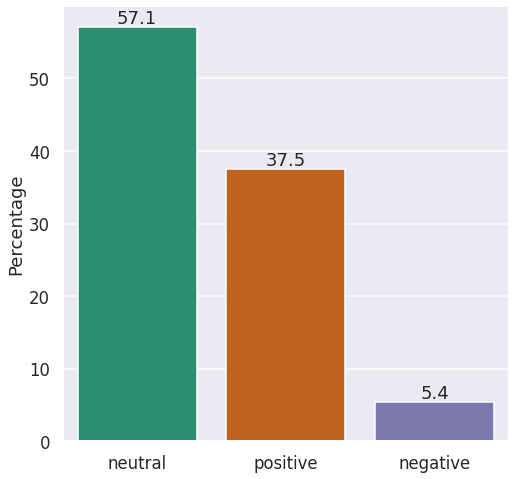

In [75]:
sns.set(style='darkgrid', context='talk', palette='Dark2')
fig, ax = plt.subplots(figsize=(8, 8))
counts = dt_2017.postivity.value_counts(normalize=True) * 100
splot = sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(counts.index)
ax.set_ylabel("Percentage")

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.savefig("Gdrive/DJ_crawling/jap_sent_pos_2017.png")
plt.show()

### 2018

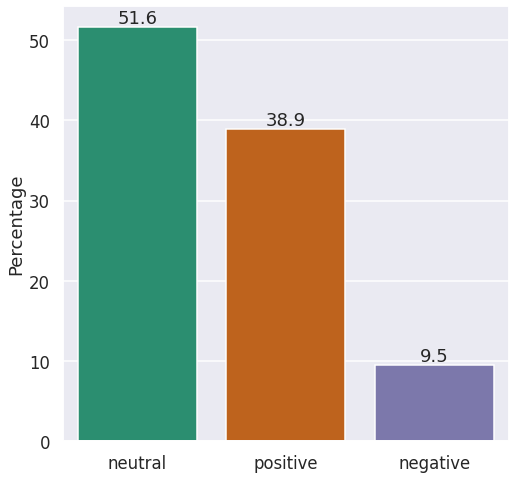

In [76]:
sns.set(style='darkgrid', context='talk', palette='Dark2')
fig, ax = plt.subplots(figsize=(8, 8))
counts = dt_2018.postivity.value_counts(normalize=True) * 100
splot = sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(counts.index)
ax.set_ylabel("Percentage")

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.savefig("Gdrive/DJ_crawling/jap_sent_pos_2018.png")
plt.show()

### 2019

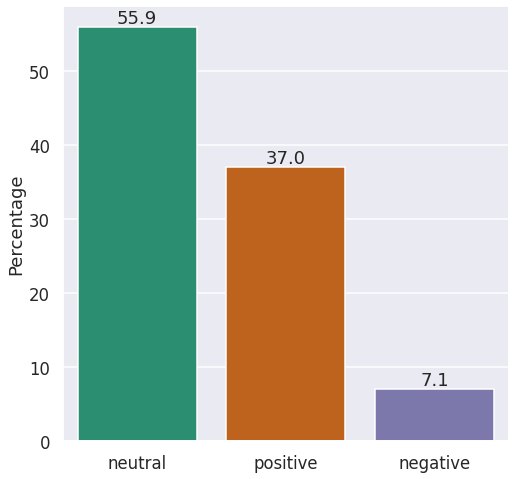

In [77]:
sns.set(style='darkgrid', context='talk', palette='Dark2')
fig, ax = plt.subplots(figsize=(8, 8))
counts = dt_2019.postivity.value_counts(normalize=True) * 100
splot = sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(counts.index)
ax.set_ylabel("Percentage")

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.savefig("Gdrive/DJ_crawling/jap_sent_pos_2019.png")
plt.show()

### 2020

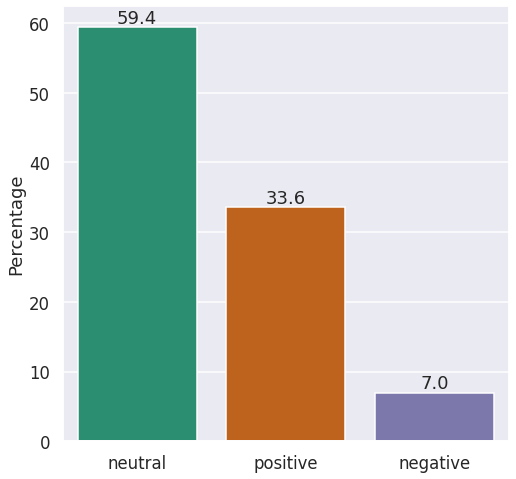

In [78]:
sns.set(style='darkgrid', context='talk', palette='Dark2')
fig, ax = plt.subplots(figsize=(8, 8))
counts = dt_2020.postivity.value_counts(normalize=True) * 100
splot = sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(counts.index)
ax.set_ylabel("Percentage")

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.savefig("Gdrive/DJ_crawling/jap_sent_pos_2020.png")
plt.show()

# Australia Data

## Load CSV

In [85]:
!ls 'Gdrive/DJ_crawling/'

2011.png			       jap_pos_2017.png
2012.png			       jap_pos_2018.png
2013.png			       jap_pos_2019.png
2014.png			       jap_pos_2020.png
2015.png			       jap_sentiment.csv
2016.png			       jap_sent_pos_2011.png
2017.png			       jap_sent_pos_2012.png
2018.png			       jap_sent_pos_2013.png
2019.png			       jap_sent_pos_2014.png
2020.png			       jap_sent_pos_2015.png
aus_pos_2011.png		       jap_sent_pos_2016.png
aus_pos_2012.png		       jap_sent_pos_2017.png
aus_pos_2013.png		       jap_sent_pos_2018.png
aus_pos_2014.png		       jap_sent_pos_2019.png
aus_pos_2015.png		       jap_sent_pos_2020.png
aus_pos_2016.png		       jap_sent_sentiment.csv
aus_pos_2017.png		       kor_pos_2011.png
aus_pos_2018.png		       kor_pos_2012.png
aus_pos_2019.png		       kor_pos_2013.png
aus_pos_2020.png		       kor_pos_2014.png
aus_sentiment.csv		       kor_pos_2015.png
data_australia.csv		       kor_pos_2016.png
data.csv			       kor_pos_2017.png
data_japan.csv			       kor_pos_2018.png
fail_data_

In [86]:
import pandas as pd 
import re
import numpy as np
import requests
from dateutil.parser import parse
aus_content = pd.read_csv('Gdrive/DJ_crawling/final_content_australia_dataframe.csv')  
aus_content['year'] = aus_content.apply(lambda row: parse(row['year'], fuzzy=True).year, axis=1)
aus_content

,title,year,content
0,"Indonesia asks Singapore, Australia to assist ...",2021,"<div class=""post-content clearfix"" style=""font..."
1,"Indonesia, Australia strengthen research colla...",2021,"<div class=""post-content clearfix"" style=""font..."
2,Humanigen Australia Proprietary Limited establ...,2020,"<div class=""post-content clearfix"" style=""font..."
3,Australia supports ASEAN's COVID-19 response e...,2020,"<div class=""post-content clearfix"" style=""font..."
4,President seeks greater economic integration b...,2020,"<div class=""post-content clearfix"" style=""font..."
...,...,...,...
656,15 are now dead in Qld flood disaster,2011,"<div class=""post-content clearfix"" style=""font..."
657,Govt urged to monitor Indonesians affected by ...,2011,"<div class=""post-content clearfix"" style=""font..."
658,Queensland flood affects 79 Indonesians,2011,"<div class=""post-content clearfix"" style=""font..."
659,"RI, Australia mulling prisoner exchange",2011,"<div class=""post-content clearfix"" style=""font..."


## Preprocessing

In [87]:
Data_list = aus_content['content'].values.tolist(); Data_list
Data_list_sub = [re.sub('<[^>]+>',' ', sub) for sub in Data_list]
Data_list_sub_2 = [re.sub(r'http\S+','', sub) for sub in Data_list_sub]
Data_list_sub_2 = [re.sub(r'\S*@\S*\s?','', sub) for sub in Data_list_sub_2]
sample = [s.strip() for s in Data_list_sub_2]
sample_df = pd.DataFrame(sample, columns=["content"]);sample_df
years=aus_content["year"].values.tolist()
sample_df['year'] = years

#split into sentence using spacy
nlp = spacy.load("en_core_web_sm")
sample_df["content"] = sample_df["content"].apply(lambda x: [sent.text for sent in nlp(x).sents])
df = sample_df.explode("content", ignore_index=True)
df.rename(columns={"Unnamed: 0": "article ID"}, inplace=True)
df.index.name = "Sentence ID"
df.head()
# Looping over every tweet in the data set and applying the tweet_cleaner function it.
clean_texts = []
for tweet in df.content:
    clean_texts.append(text_cleaner(tweet))
clean_texts
# merge with original data the clean test
df['clean_text'] = clean_texts
df

,content,year,clean_text
Sentence ID,,,
0,Jakarta (ANTARA) - Indonesia has sought help f...,2021,jakarta antara indonesia have seek help from s...
1,"KRI Nanggala-402, which went missing in the w...",2021,kri nanggala which go miss in the water north ...
2,"""We have had good cooperation with Singapore a...",2021,we have have good cooperation with singapore a...
3,Besides appealing to the two friendly countrie...,2021,besides appeal to the two friendly country for...
4,"Contact with German-made KRI Nanggala-402 , w...",2021,contact with german make kri nanggala which be...
...,...,...,...
11363,Now approaching its ninth year and a highly re...,2011,now approach its ninth year and a highly regar...
11364,Paramadina University has acted as a valued pa...,2011,paramadina university have act as a value part...
11365,The program is funded by the Australian Govern...,2011,the program be fund by the australian governme...


## Get Afinn Scores

In [88]:
# Sentiment analysis with AFINN
afinn = Afinn(emoticons=True)
afinn_scores = [afinn.score(clean_text) for clean_text in df.clean_text]

#add label
predicted_sentiments = []
for score in afinn_scores:
  if score >= 1:
    predicted_sentiments.append("positive")
  elif score <= -1:
    predicted_sentiments.append("negative")
  else:
    predicted_sentiments.append("neutral")
df['postivity'] = predicted_sentiments ;df

df.to_csv('aus_sent_sentiment.csv')
!cp aus_sent_sentiment.csv "Gdrive/DJ_crawling/"

## Analyzing yearly positivity

In [89]:
subset_df_2011 = df["year"] == 2011
subset_df_2012 = df["year"] == 2012
subset_df_2013 = df["year"] == 2013
subset_df_2014 = df["year"] == 2014
subset_df_2015 = df["year"] == 2015
subset_df_2016 = df["year"] == 2016
subset_df_2017 = df["year"] == 2017
subset_df_2018 = df["year"] == 2018
subset_df_2019 = df["year"] == 2019
subset_df_2020 = df["year"] == 2020

dt_2011 = df[subset_df_2011]
dt_2012 = df[subset_df_2012]
dt_2013 = df[subset_df_2013]
dt_2014 = df[subset_df_2014]
dt_2015 = df[subset_df_2015]
dt_2016 = df[subset_df_2016]
dt_2017 = df[subset_df_2017]
dt_2018 = df[subset_df_2018]
dt_2019 = df[subset_df_2019]
dt_2020 = df[subset_df_2020]

# Data_list_2011=dt_2011["content"].values.tolist()
# Data_list_2012=dt_2012["content"].values.tolist()
# Data_list_2013=dt_2013["content"].values.tolist()
# Data_list_2014=dt_2014["content"].values.tolist()
# Data_list_2015=dt_2015["content"].values.tolist()
# Data_list_2016=dt_2016["content"].values.tolist()
# Data_list_2017=dt_2017["content"].values.tolist()
# Data_list_2018=dt_2018["content"].values.tolist()
# Data_list_2019=dt_2019["content"].values.tolist()
# Data_list_2020=dt_2020["content"].values.tolist()

### 2011

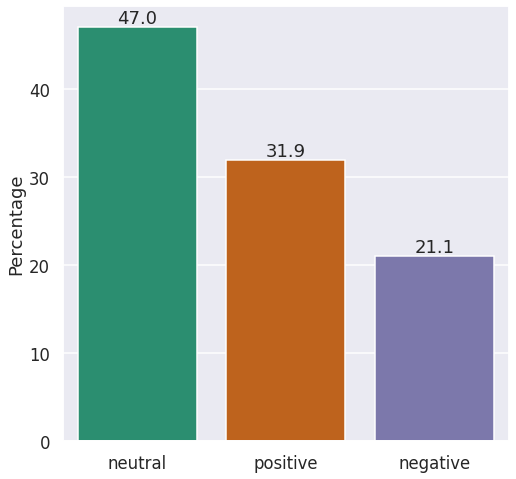

In [90]:
sns.set(style='darkgrid', context='talk', palette='Dark2')
fig, ax = plt.subplots(figsize=(8, 8))
counts = dt_2011.postivity.value_counts(normalize=True) * 100
splot = sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(counts.index)
ax.set_ylabel("Percentage")

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.savefig("Gdrive/DJ_crawling/aus_sent_pos_2011.png")
plt.show()

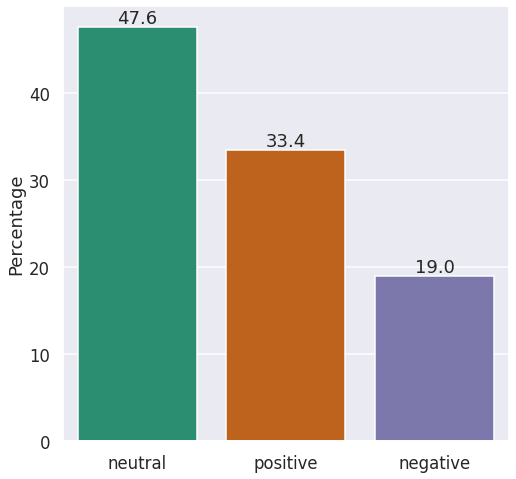

In [91]:
sns.set(style='darkgrid', context='talk', palette='Dark2')
fig, ax = plt.subplots(figsize=(8, 8))
counts = dt_2012.postivity.value_counts(normalize=True) * 100
splot = sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(counts.index)
ax.set_ylabel("Percentage")

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.savefig("Gdrive/DJ_crawling/aus_sent_pos_2012.png")
plt.show()

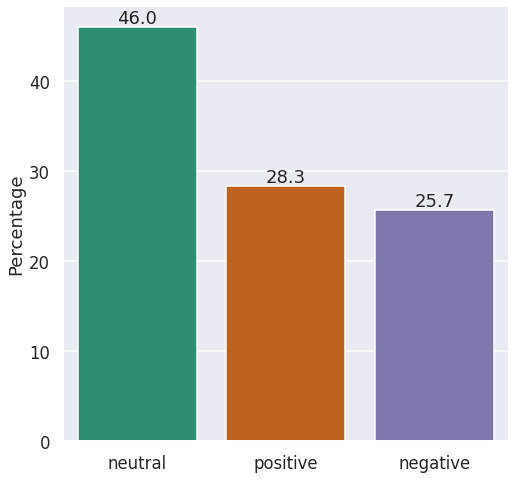

In [92]:
sns.set(style='darkgrid', context='talk', palette='Dark2')
fig, ax = plt.subplots(figsize=(8, 8))
counts = dt_2013.postivity.value_counts(normalize=True) * 100
splot = sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(counts.index)
ax.set_ylabel("Percentage")

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.savefig("Gdrive/DJ_crawling/aus_sent_pos_2013.png")
plt.show()

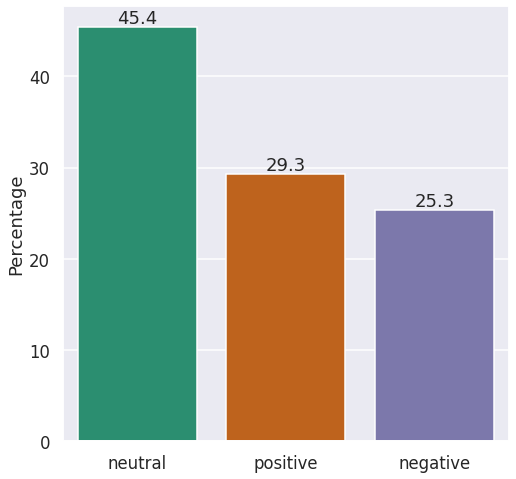

In [93]:
sns.set(style='darkgrid', context='talk', palette='Dark2')
fig, ax = plt.subplots(figsize=(8, 8))
counts = dt_2014.postivity.value_counts(normalize=True) * 100
splot = sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(counts.index)
ax.set_ylabel("Percentage")

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.savefig("Gdrive/DJ_crawling/aus_sent_pos_2014.png")
plt.show()

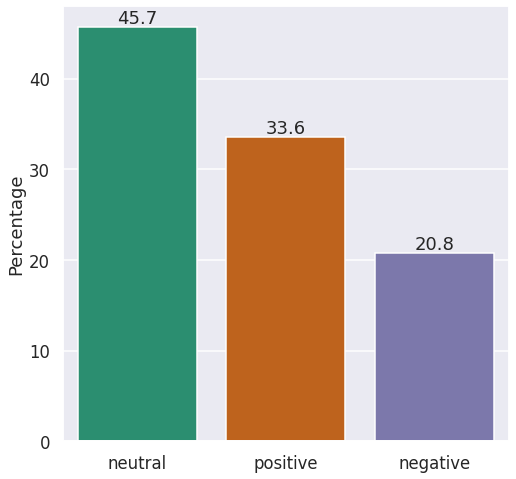

In [94]:
sns.set(style='darkgrid', context='talk', palette='Dark2')
fig, ax = plt.subplots(figsize=(8, 8))
counts = dt_2015.postivity.value_counts(normalize=True) * 100
splot = sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(counts.index)
ax.set_ylabel("Percentage")

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.savefig("Gdrive/DJ_crawling/aus_sent_pos_2015.png")
plt.show()

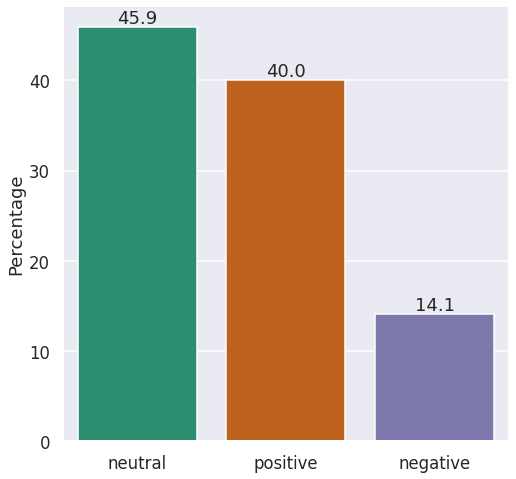

In [95]:
sns.set(style='darkgrid', context='talk', palette='Dark2')
fig, ax = plt.subplots(figsize=(8, 8))
counts = dt_2016.postivity.value_counts(normalize=True) * 100
splot = sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(counts.index)
ax.set_ylabel("Percentage")

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.savefig("Gdrive/DJ_crawling/aus_sent_pos_2016.png")
plt.show()

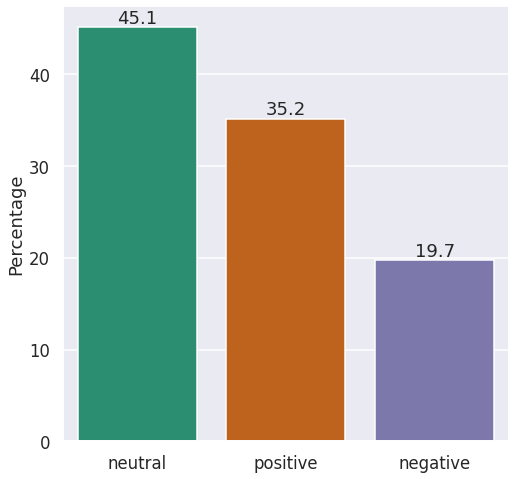

In [96]:
sns.set(style='darkgrid', context='talk', palette='Dark2')
fig, ax = plt.subplots(figsize=(8, 8))
counts = dt_2017.postivity.value_counts(normalize=True) * 100
splot = sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(counts.index)
ax.set_ylabel("Percentage")

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.savefig("Gdrive/DJ_crawling/aus_sent_pos_2017.png")
plt.show()

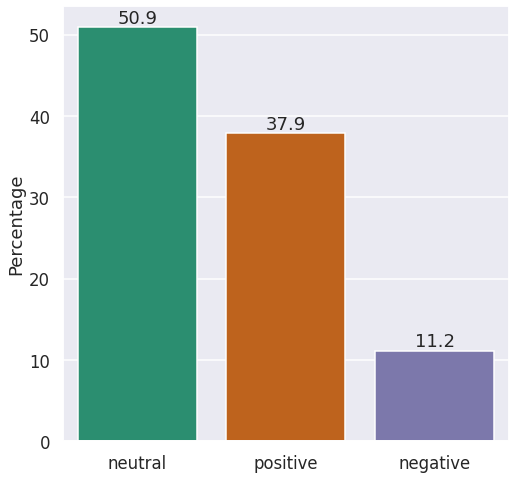

In [97]:
sns.set(style='darkgrid', context='talk', palette='Dark2')
fig, ax = plt.subplots(figsize=(8, 8))
counts = dt_2018.postivity.value_counts(normalize=True) * 100
splot = sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(counts.index)
ax.set_ylabel("Percentage")

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.savefig("Gdrive/DJ_crawling/aus_sent_pos_2018.png")
plt.show()

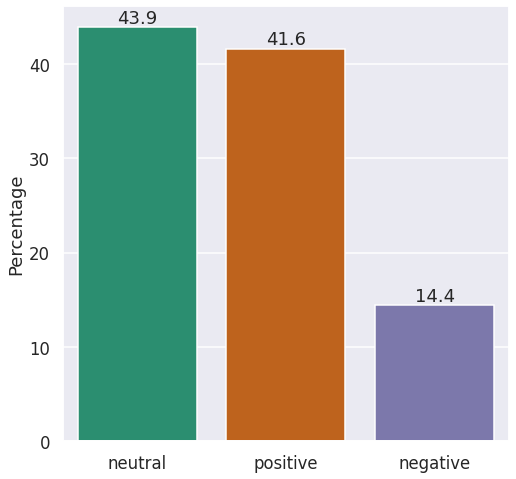

In [98]:
sns.set(style='darkgrid', context='talk', palette='Dark2')
fig, ax = plt.subplots(figsize=(8, 8))
counts = dt_2019.postivity.value_counts(normalize=True) * 100
splot = sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(counts.index)
ax.set_ylabel("Percentage")

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.savefig("Gdrive/DJ_crawling/aus_sent_pos_2019.png")
plt.show()

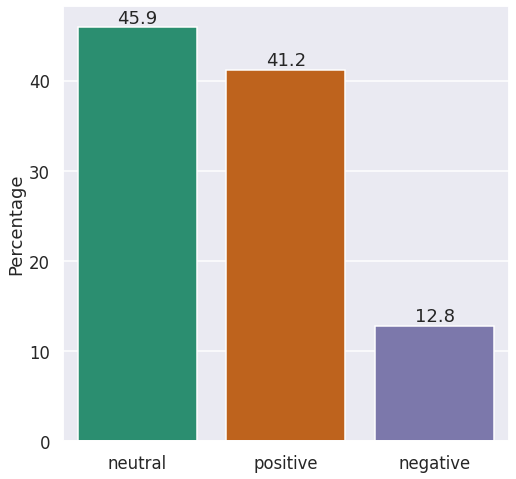

In [99]:
sns.set(style='darkgrid', context='talk', palette='Dark2')
fig, ax = plt.subplots(figsize=(8, 8))
counts = dt_2020.postivity.value_counts(normalize=True) * 100
splot = sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(counts.index)
ax.set_ylabel("Percentage")

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.savefig("Gdrive/DJ_crawling/aus_sent_pos_2020.png")
plt.show()

# US data

## Load CSV

In [100]:
!ls 'Gdrive/DJ_crawling/'

2011.png			       jap_pos_2011.png
2012.png			       jap_pos_2012.png
2013.png			       jap_pos_2013.png
2014.png			       jap_pos_2014.png
2015.png			       jap_pos_2015.png
2016.png			       jap_pos_2016.png
2017.png			       jap_pos_2017.png
2018.png			       jap_pos_2018.png
2019.png			       jap_pos_2019.png
2020.png			       jap_pos_2020.png
aus_pos_2011.png		       jap_sentiment.csv
aus_pos_2012.png		       jap_sent_pos_2011.png
aus_pos_2013.png		       jap_sent_pos_2012.png
aus_pos_2014.png		       jap_sent_pos_2013.png
aus_pos_2015.png		       jap_sent_pos_2014.png
aus_pos_2016.png		       jap_sent_pos_2015.png
aus_pos_2017.png		       jap_sent_pos_2016.png
aus_pos_2018.png		       jap_sent_pos_2017.png
aus_pos_2019.png		       jap_sent_pos_2018.png
aus_pos_2020.png		       jap_sent_pos_2019.png
aus_sentiment.csv		       jap_sent_pos_2020.png
aus_sent_pos_2011.png		       jap_sent_sentiment.csv
aus_sent_pos_2012.png		       kor_pos_2011.png
aus_sent_pos_2013.png		       kor_po

In [101]:
import pandas as pd 
import re
import numpy as np
import requests
from dateutil.parser import parse
us_content1 = pd.read_csv('Gdrive/DJ_crawling/final_content_us_dataframe1.csv')
us_content2 = pd.read_csv('Gdrive/DJ_crawling/final_content_us_dataframe2.csv') 

In [106]:
us_content2.tail()

,title,year,content
1145,RI-US oceanic expedition benefited both sides:...,7th January 2011,"<div class=""post-content clearfix"" style=""font..."
1146,"Indonesia, US discuss results of joining ocean...",7th January 2011,"<div class=""post-content clearfix"" style=""font..."
1147,Vegetable seed exports reach US$22.67 million,6th January 2011,"<div class=""post-content clearfix"" style=""font..."
1148,US continues maintaining RI`s F-16 Falcons,5th January 2011,"<div class=""post-content clearfix"" style=""font..."
1149,"Children speaking up about crime, abuse: US Study",4th January 2011,"<div class=""post-content clearfix"" style=""font..."


In [107]:
us_content = us_content1.append(us_content2)
display(us_content)

,title,year,content
0,CPO exports fetch US$3.74 billion in March,30th April 2021,"<div class=""post-content clearfix"" style=""font..."
1,MessageBird acquires US-based SparkPost for $6...,29th April 2021,"<div class=""post-content clearfix"" style=""font..."
2,US declares $3.5 million fund for Indonesia's...,27th April 2021,"<div class=""post-content clearfix"" style=""font..."
3,Indonesia's digital economy potential in 2025 ...,23rd April 2021,"<div class=""post-content clearfix"" style=""font..."
4,Muslim journalists from US share Ramadhan expe...,21st April 2021,"<div class=""post-content clearfix"" style=""font..."
...,...,...,...
1145,RI-US oceanic expedition benefited both sides:...,7th January 2011,"<div class=""post-content clearfix"" style=""font..."
1146,"Indonesia, US discuss results of joining ocean...",7th January 2011,"<div class=""post-content clearfix"" style=""font..."
1147,Vegetable seed exports reach US$22.67 million,6th January 2011,"<div class=""post-content clearfix"" style=""font..."
1148,US continues maintaining RI`s F-16 Falcons,5th January 2011,"<div class=""post-content clearfix"" style=""font..."


In [108]:
us_content.reset_index(drop=True, inplace=True) ;us_content

,title,year,content
0,CPO exports fetch US$3.74 billion in March,30th April 2021,"<div class=""post-content clearfix"" style=""font..."
1,MessageBird acquires US-based SparkPost for $6...,29th April 2021,"<div class=""post-content clearfix"" style=""font..."
2,US declares $3.5 million fund for Indonesia's...,27th April 2021,"<div class=""post-content clearfix"" style=""font..."
3,Indonesia's digital economy potential in 2025 ...,23rd April 2021,"<div class=""post-content clearfix"" style=""font..."
4,Muslim journalists from US share Ramadhan expe...,21st April 2021,"<div class=""post-content clearfix"" style=""font..."
...,...,...,...
2146,RI-US oceanic expedition benefited both sides:...,7th January 2011,"<div class=""post-content clearfix"" style=""font..."
2147,"Indonesia, US discuss results of joining ocean...",7th January 2011,"<div class=""post-content clearfix"" style=""font..."
2148,Vegetable seed exports reach US$22.67 million,6th January 2011,"<div class=""post-content clearfix"" style=""font..."
2149,US continues maintaining RI`s F-16 Falcons,5th January 2011,"<div class=""post-content clearfix"" style=""font..."


In [110]:
us_content['year'] = us_content.apply(lambda row: parse(row['year'], fuzzy=True).year, axis=1)
us_content

,title,year,content
0,CPO exports fetch US$3.74 billion in March,2021,"<div class=""post-content clearfix"" style=""font..."
1,MessageBird acquires US-based SparkPost for $6...,2021,"<div class=""post-content clearfix"" style=""font..."
2,US declares $3.5 million fund for Indonesia's...,2021,"<div class=""post-content clearfix"" style=""font..."
3,Indonesia's digital economy potential in 2025 ...,2021,"<div class=""post-content clearfix"" style=""font..."
4,Muslim journalists from US share Ramadhan expe...,2021,"<div class=""post-content clearfix"" style=""font..."
...,...,...,...
2146,RI-US oceanic expedition benefited both sides:...,2011,"<div class=""post-content clearfix"" style=""font..."
2147,"Indonesia, US discuss results of joining ocean...",2011,"<div class=""post-content clearfix"" style=""font..."
2148,Vegetable seed exports reach US$22.67 million,2011,"<div class=""post-content clearfix"" style=""font..."
2149,US continues maintaining RI`s F-16 Falcons,2011,"<div class=""post-content clearfix"" style=""font..."


## Preprocess Tag

In [111]:
Data_list = us_content['content'].values.tolist(); Data_list
Data_list_sub = [re.sub('<[^>]+>',' ', sub) for sub in Data_list]
Data_list_sub_2 = [re.sub(r'http\S+','', sub) for sub in Data_list_sub]
Data_list_sub_2 = [re.sub(r'\S*@\S*\s?','', sub) for sub in Data_list_sub_2]
sample = [s.strip() for s in Data_list_sub_2]
sample_df = pd.DataFrame(sample, columns=["content"]);sample_df
years=us_content["year"].values.tolist()
sample_df['year'] = years

#split into sentence using spacy
nlp = spacy.load("en_core_web_sm")
sample_df["content"] = sample_df["content"].apply(lambda x: [sent.text for sent in nlp(x).sents])
df = sample_df.explode("content", ignore_index=True)
df.rename(columns={"Unnamed: 0": "article ID"}, inplace=True)
df.index.name = "Sentence ID"
df.head()
# Looping over every tweet in the data set and applying the tweet_cleaner function it.
clean_texts = []
for tweet in df.content:
    clean_texts.append(text_cleaner(tweet))
clean_texts
# merge with original data the clean test
df['clean_text'] = clean_texts
df

,content,year,clean_text
Sentence ID,,,
0,An increase in price and volume is believed to...,2021,an increase in price and volume be believe to ...
1,Jakarta (ANTARA) -,2021,jakarta antara
2,Indonesia’s crude palm oil (CPO) exports in Ma...,2021,indonesias crude palm oil cpo export in march ...
3,The foreign exchange earnings were obtained fr...,2021,the foreign exchange earning be obtain from th...
4,“An increase in price and volume is believed t...,2021,an increase in price and volume be believe to ...
...,...,...,...
34023,But they they also show that many children are...,2011,but they they also show that many child be sti...
34024,"""That 58.3 percent of the children and adolesc...",2011,that percent of the child and adolescent in th...
34025,Andrea Gottsegen Asnes and John Leventhal of Y...,2011,andrea gottsegen asnes and john leventhal of y...


## Get Afinn Scores

In [112]:
# afinn = Afinn(emoticons = True)
# afinn.score('This is utterly excellent!;)')

# Sentiment analysis with AFINN
afinn = Afinn(emoticons=True)
afinn_scores = [afinn.score(clean_text) for clean_text in df.clean_text]

#add label
predicted_sentiments = []
for score in afinn_scores:
  if score >= 1:
    predicted_sentiments.append("positive")
  elif score <= -1:
    predicted_sentiments.append("negative")
  else:
    predicted_sentiments.append("neutral")
df['postivity'] = predicted_sentiments ;df

df.to_csv('us_sent_sentiment.csv')
!cp us_sent_sentiment.csv "Gdrive/DJ_crawling/"

## Analyzing Yearly positivity

In [113]:
subset_df_2011 = df["year"] == 2011
subset_df_2012 = df["year"] == 2012
subset_df_2013 = df["year"] == 2013
subset_df_2014 = df["year"] == 2014
subset_df_2015 = df["year"] == 2015
subset_df_2016 = df["year"] == 2016
subset_df_2017 = df["year"] == 2017
subset_df_2018 = df["year"] == 2018
subset_df_2019 = df["year"] == 2019
subset_df_2020 = df["year"] == 2020

dt_2011 = df[subset_df_2011]
dt_2012 = df[subset_df_2012]
dt_2013 = df[subset_df_2013]
dt_2014 = df[subset_df_2014]
dt_2015 = df[subset_df_2015]
dt_2016 = df[subset_df_2016]
dt_2017 = df[subset_df_2017]
dt_2018 = df[subset_df_2018]
dt_2019 = df[subset_df_2019]
dt_2020 = df[subset_df_2020]

# Data_list_2011=dt_2011["content"].values.tolist()
# Data_list_2012=dt_2012["content"].values.tolist()
# Data_list_2013=dt_2013["content"].values.tolist()
# Data_list_2014=dt_2014["content"].values.tolist()
# Data_list_2015=dt_2015["content"].values.tolist()
# Data_list_2016=dt_2016["content"].values.tolist()
# Data_list_2017=dt_2017["content"].values.tolist()
# Data_list_2018=dt_2018["content"].values.tolist()
# Data_list_2019=dt_2019["content"].values.tolist()
# Data_list_2020=dt_2020["content"].values.tolist()

### 2011

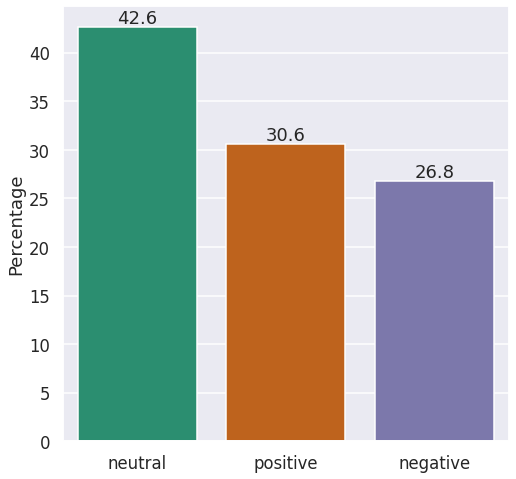

In [135]:
sns.set(style='darkgrid', context='talk', palette='Dark2')
fig, ax = plt.subplots(figsize=(8, 8))
counts = dt_2011.postivity.value_counts(normalize=True) * 100
splot = sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(counts.index)
ax.set_ylabel("Percentage")

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.savefig("Gdrive/DJ_crawling/us_sent_pos_2011.png")
plt.show()

### 2012

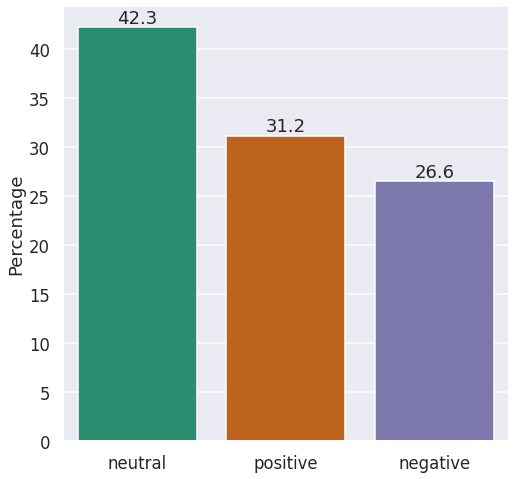

In [136]:
sns.set(style='darkgrid', context='talk', palette='Dark2')
fig, ax = plt.subplots(figsize=(8, 8))
counts = dt_2012.postivity.value_counts(normalize=True) * 100
splot = sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(counts.index)
ax.set_ylabel("Percentage")

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.savefig("Gdrive/DJ_crawling/us_sent_pos_2012.png")
plt.show()

## 2013

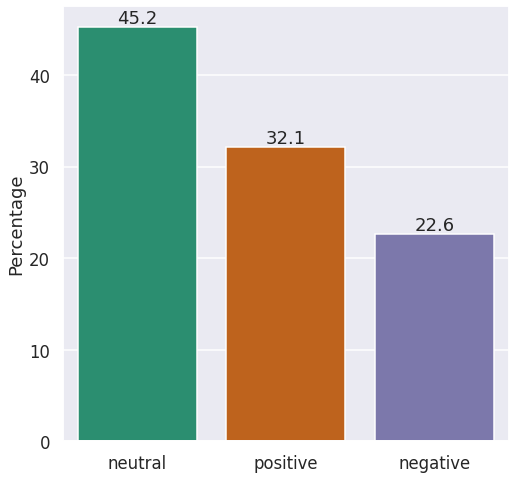

In [137]:
sns.set(style='darkgrid', context='talk', palette='Dark2')
fig, ax = plt.subplots(figsize=(8, 8))
counts = dt_2013.postivity.value_counts(normalize=True) * 100
splot = sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(counts.index)
ax.set_ylabel("Percentage")

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.savefig("Gdrive/DJ_crawling/us_sent_pos_2013.png")
plt.show()

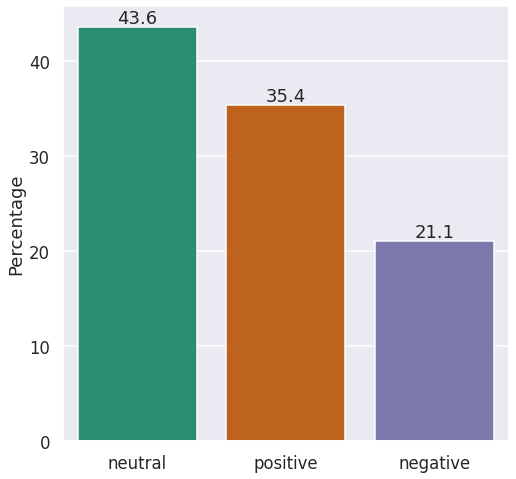

In [138]:
sns.set(style='darkgrid', context='talk', palette='Dark2')
fig, ax = plt.subplots(figsize=(8, 8))
counts = dt_2014.postivity.value_counts(normalize=True) * 100
splot = sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(counts.index)
ax.set_ylabel("Percentage")

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.savefig("Gdrive/DJ_crawling/us_sent_pos_2014.png")
plt.show()

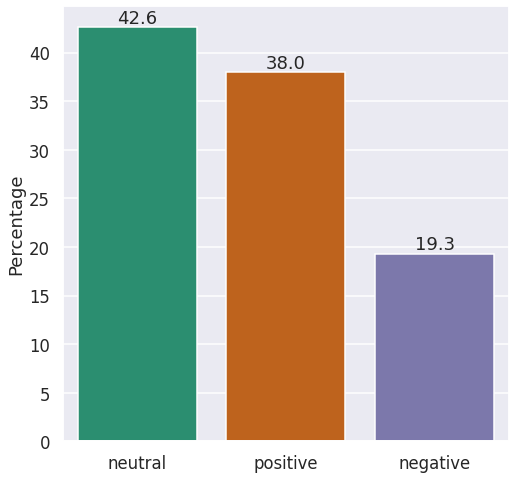

In [129]:
sns.set(style='darkgrid', context='talk', palette='Dark2')
fig, ax = plt.subplots(figsize=(8, 8))
counts = dt_2015.postivity.value_counts(normalize=True) * 100
splot = sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(counts.index)
ax.set_ylabel("Percentage")

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.savefig("Gdrive/DJ_crawling/us_sent_pos_2015.png")
plt.show()

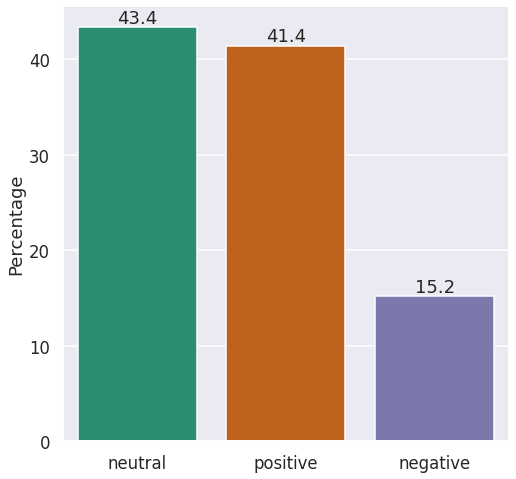

In [130]:
sns.set(style='darkgrid', context='talk', palette='Dark2')
fig, ax = plt.subplots(figsize=(8, 8))
counts = dt_2016.postivity.value_counts(normalize=True) * 100
splot = sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(counts.index)
ax.set_ylabel("Percentage")

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.savefig("Gdrive/DJ_crawling/us_sent_pos_2016.png")
plt.show()

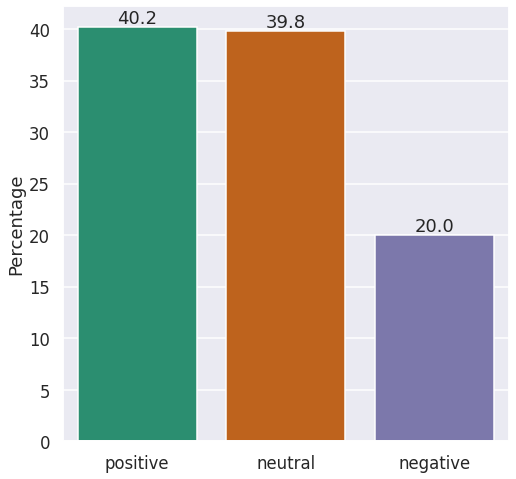

In [131]:
sns.set(style='darkgrid', context='talk', palette='Dark2')
fig, ax = plt.subplots(figsize=(8, 8))
counts = dt_2017.postivity.value_counts(normalize=True) * 100
splot = sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(counts.index)
ax.set_ylabel("Percentage")

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.savefig("Gdrive/DJ_crawling/us_sent_pos_2017.png")
plt.show()

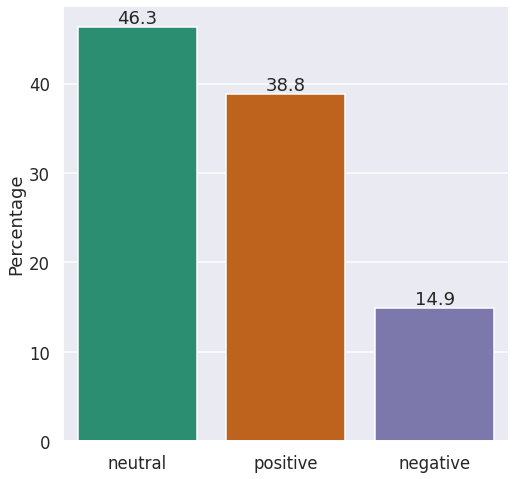

In [132]:
sns.set(style='darkgrid', context='talk', palette='Dark2')
fig, ax = plt.subplots(figsize=(8, 8))
counts = dt_2018.postivity.value_counts(normalize=True) * 100
splot = sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(counts.index)
ax.set_ylabel("Percentage")

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.savefig("Gdrive/DJ_crawling/us_sent_pos_2018.png")
plt.show()

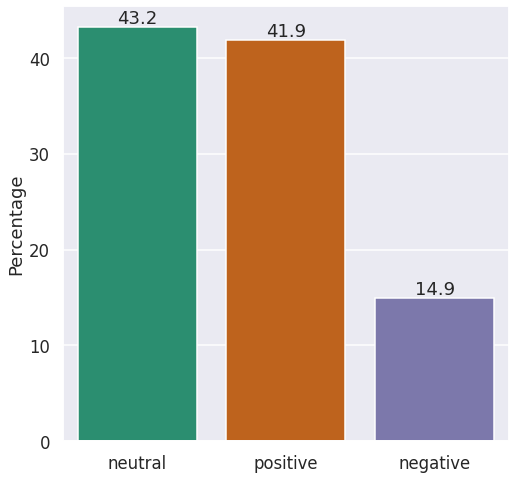

In [133]:
sns.set(style='darkgrid', context='talk', palette='Dark2')
fig, ax = plt.subplots(figsize=(8, 8))
counts = dt_2019.postivity.value_counts(normalize=True) * 100
splot = sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(counts.index)
ax.set_ylabel("Percentage")

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.savefig("Gdrive/DJ_crawling/us_sent_pos_2019.png")
plt.show()

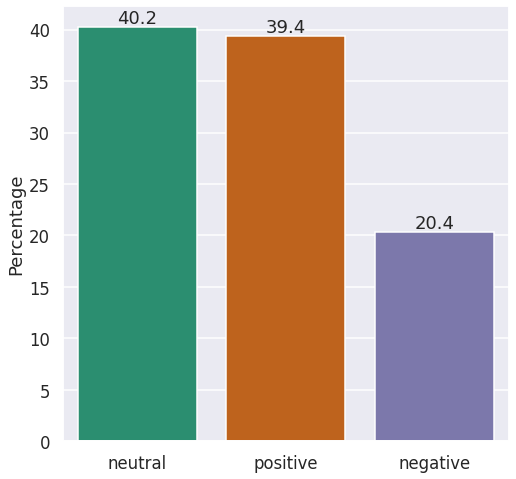

In [134]:
sns.set(style='darkgrid', context='talk', palette='Dark2')
fig, ax = plt.subplots(figsize=(8, 8))
counts = dt_2020.postivity.value_counts(normalize=True) * 100
splot = sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(counts.index)
ax.set_ylabel("Percentage")

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.savefig("Gdrive/DJ_crawling/us_sent_pos_2020.png")
plt.show()